In [46]:
from extract.extract import getTLEsFromLaunches, getCredentials
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
# import sklearn
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import export_graphviz
from sklearn.utils import shuffle

import xgboost as xgb

start = datetime(2016, 1, 1)
end = datetime(2023, 1, 1)

token = getCredentials(source="discos")
username, password = getCredentials(source="spacetrack")

# launchIDs = ["2013-066", "2018-092", "2019-084", "2022-002"]
# launchIDs = ["2013-066", "2018-092", "2019-084", "2022-002", "2021-006"]
launchIDs = ["2013-066"]
# launchIDs = ["2022-002"]
# launchIDs = ["2019-084"]
# launchIDs = ["2021-059"]
launchIDs = ["2018-092"]
ignoreList = [44827, 44828, 44829, 44830, 44831, 44832] + [39435, 39436, 39437] + [43704, 44046]
# combining everything into one DF
discosDataDict, dfOriginal = getTLEsFromLaunches(
    username,
    password,
    token,
    launchIDs,
    start,
    end,
    combineDiscosAndTLE=True,
    collectLaunches=True,
    collectAllTLEs=True,
    forceRegen=False,
    ignoreList=ignoreList
)


Launch: 2018-092: 100%|██████████| 4/4 [00:00<00:00, 12.28it/s]

Skipped NORADid 43704
Skipped NORADid 44046


In [47]:
# print(dfOriginal.columns)
print(f"original length: {len(dfOriginal)}")
df = dfOriginal.query("overallCovariance < 5")#.query("RCS_SIZE == 'SMALL'")
print(f"reduced length: {len(df)}")

colsToDrop = [
       'vimpelId', 'OBJECT_NAME', 'CENTER_NAME',
       'MEAN_MOTION', 'RA_OF_ASC_NODE',
       'ARG_OF_PERICENTER', 'MEAN_ANOMALY', 'NORAD_CAT_ID', 'ELEMENT_SET_NO',
       'REV_AT_EPOCH', 'BSTAR', 'MEAN_MOTION_DOT', 'MEAN_MOTION_DDOT',
        'PERIOD', 'COUNTRY_CODE', 'LAUNCH_DATE', 'DECAY_DATE', 'TLE_LINE0', "OBJECT_TYPE", "objectClass", 
       'TLE_LINE1', 'TLE_LINE2', 'TLE_LINE1min1', 'TLE_LINE2min1']

df = df.drop(colsToDrop, axis=1)


print(df.groupby("shape").size())

original length: 13028
reduced length: 12891
shape
Box            10435
Box + 1 Pan     2456
dtype: int64


### Create ML dataset

In [48]:
# Get ML dataset
colsToDrop = ["name", "cosparId", "shape", "diameter", "EPOCH", "satno"]
colsToDrop2 = ["ECCENTRICITY", "INCLINATION", "PERIAPSIS", "APOAPSIS", "SEMIMAJOR_AXIS", "deltat"]
colsToDrop3 = ['height', "width", "depth", 'xSectAvg']     
labels = ["errorX", "errorY", "errorZ", "errorCross", "errorAlong", "errorRadial", "overallCovariance", "overallVelocityCovariance", "actualX", "actualY", "actualZ"]

# dfML = df.drop(colsToDrop, axis=1).drop(colsToDrop2, axis=1)
dfML = df.drop(colsToDrop, axis=1).drop(colsToDrop3, axis=1).drop(colsToDrop2, axis=1)
# dfML = df.drop(colsToDrop, axis=1).drop(colsToDrop3, axis=1)
# dfML = df.drop(colsToDrop, axis=1)
print(df.columns)
# print(df.head())
print("nan analyiss")
# print(dfFeatures.describe())
print("With NaN", len(df))
dfML = dfML.dropna()
print("Without NaN", len(df))
print("nan analyiss")
# dfLabels = dfML[["errorCross", "errorAlong", "errorRadial"]]
# dfLabels = dfML[["errorAlong"]]
# dfLabels = dfML[["overallCovariance"]]
dfLabels = dfML[["errorX", "errorY", "errorZ"]]
# dfLabels = dfML[["actualX", "actualY", "actualZ"]]
dfFeatures = dfML.drop(labels, axis=1)


# print(dfML.head())
print(dfFeatures.RCS_SIZE.unique())
print(dfFeatures.groupby("RCS_SIZE").size())

# encode RCS_SIZE
# encoding = [[value, idx] for idx, value in enumerate(dfML.RCS_SIZE.unique())]
cats = list(dfFeatures.RCS_SIZE.unique())
enc_RCS_SIZE = LabelEncoder()
enc_RCS_SIZE.fit(dfFeatures.RCS_SIZE)
dfFeatures.RCS_SIZE = enc_RCS_SIZE.transform(dfFeatures.RCS_SIZE)
# print(dfFeatures)

columnsFeatures = list(dfFeatures.columns)
columnsLabels = list(dfLabels.columns)

scalerX = RobustScaler()
scalerY = RobustScaler()

scalerX.fit(dfFeatures)
X = scalerX.transform(dfFeatures)

# scalerY.fit(dfLabels)
# y = scalerY.transform(dfLabels)[:, 0]
y=dfLabels.to_numpy()

print(y.shape)

Index(['depth', 'name', 'cosparId', 'xSectAvg', 'shape', 'width', 'xSectMax',
       'height', 'diameter', 'xSectMin', 'mass', 'span', 'satno', 'antennas',
       'pannels', 'rods', 'volume', 'EPOCH', 'ECCENTRICITY', 'INCLINATION',
       'SEMIMAJOR_AXIS', 'APOAPSIS', 'PERIAPSIS', 'RCS_SIZE', 'deltat',
       'errorX', 'errorY', 'errorZ', 'errorCross', 'errorAlong', 'errorRadial',
       'overallCovariance', 'overallVelocityCovariance', 'simX', 'simY',
       'simZ', 'actualX', 'actualY', 'actualZ'],
      dtype='object')
nan analyiss
With NaN 12891
Without NaN 12891
nan analyiss
['SMALL' 'MEDIUM']
RCS_SIZE
MEDIUM       22
SMALL     12783
dtype: int64
(12805, 3)


Remember: Size is unbalanced

In [49]:
model = xgb.XGBRegressor()
model.load_model("xgb1.json")
ymodel = model.predict(X)

Gradient Boost | MSE = 0.6724316800148527, MAE = 0.48152267830903844, R2-score = -0.3789642839299894


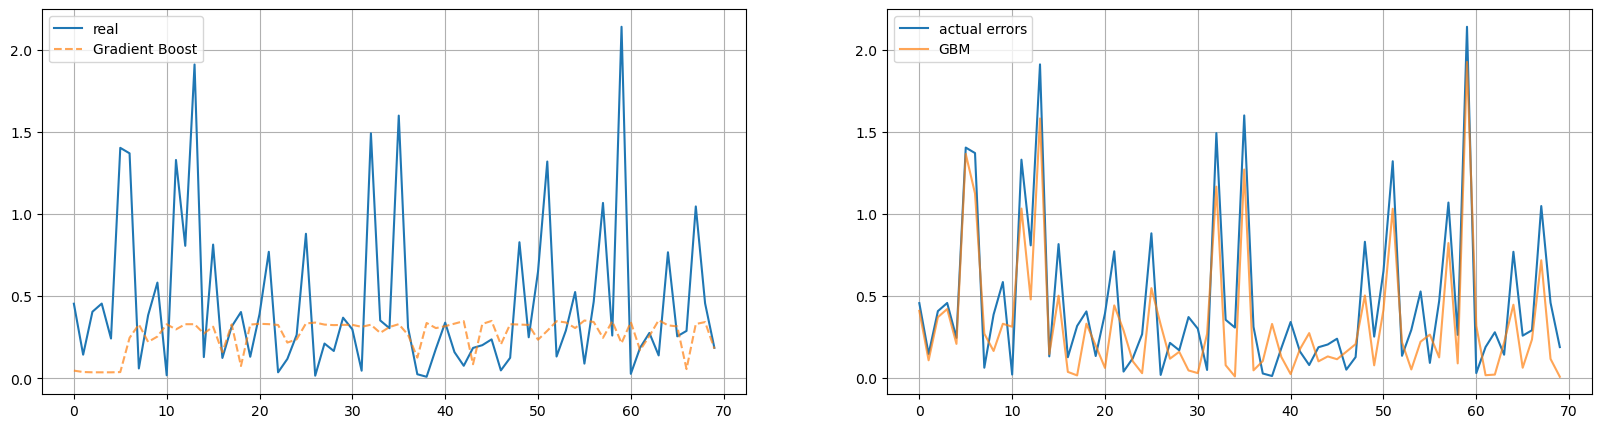

In [50]:
y_predict = np.sqrt(np.square(ymodel).sum(axis=1))
y_real = np.sqrt(np.square(y).sum(axis=1))

MSE_GBM = mean_squared_error(y_real, y_predict)
MAE_GBM = mean_absolute_error(y_real, y_predict)
R2_GBM = r2_score(y_real, y_predict)

fig, ax = plt.subplots(1, 2, figsize=(20,5))
sampleStart = 700
sampleSize = 70
feat = 0
errorsOrig = dfML.overallCovariance.to_numpy()

ax[0].plot(y_real[sampleStart:(sampleStart + sampleSize)], label="real")
ax[0].plot(y_predict[sampleStart:(sampleStart + sampleSize)], linestyle="--", label="Gradient Boost", alpha=0.7)

ax[1].plot(errorsOrig[sampleStart:(sampleStart + sampleSize)], label="actual errors")
ax[1].plot(np.abs(y_real[sampleStart:(sampleStart + sampleSize)] - y_predict[sampleStart:(sampleStart + sampleSize)]), label="GBM", alpha=0.7)

ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()

print(f"Gradient Boost | MSE = {MSE_GBM}, MAE = {MAE_GBM}, R2-score = {R2_GBM}")
